In [9]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import keras.backend as K
from scipy.ndimage import gaussian_filter
import xarray as xr
%matplotlib inline

In [63]:
ls /glade/scratch/dgagne/hfip/processed_data_dv_lossy/

best_track_all.csv  hwrf_local_norm_stats.nc  hwrf_norm/


In [2]:
res_model = load_model("/glade/scratch/dgagne/hfip/hfip_models_dv_20190824/conv_small/conv_small_e_15.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [48]:
res_model_2 = load_model("/glade/scratch/dgagne/hfip/hfip_models_dv_20190824/conv_res/conv_res_e_15.h5")

In [49]:
res_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         (None, 9, 384, 384)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 384, 384) 984         conv_input[0][0]                 
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 12, 384, 384) 48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
res_activation_00_a (LeakyReLU) (None, 12, 384, 384) 0           bn_res_00_a[0][0]                
____________________________________________________________________________________________

In [46]:
res_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_input (InputLayer)      (None, 9, 384, 384)       0         
_________________________________________________________________
conv_00 (Conv2D)             (None, 12, 384, 384)      984       
_________________________________________________________________
hidden_activation_00 (LeakyR (None, 12, 384, 384)      0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 12, 384, 384)      0         
_________________________________________________________________
pooling_00 (AveragePooling2D (None, 12, 192, 192)      0         
_________________________________________________________________
conv_01 (Conv2D)             (None, 18, 192, 192)      1962      
_________________________________________________________________
hidden_activation_01 (LeakyR (None, 18, 192, 192)      0   

In [3]:
norms = xr.open_dataset("/glade/scratch/dgagne/hfip/processed_data_dv_lossy/hwrf_local_norm_stats.nc")

In [12]:
loss = (res_model.output - 100) ** 2
grad = K.gradients(loss, [res_model.input])[0]
opt_func = K.function([res_model.input, K.learning_phase()], [grad, loss])
in_field = np.zeros((1, 9, 384, 384))
for i in range(200):
    grad_field, loss_val = opt_func([in_field, 0])
    in_field -= grad_field
    print(loss_val[0, 0])

11233.525
8875.224
8184.8237
7683.265
7233.181
6813.3696
6416.6807
6043.8574
5689.927
5353.9927
5035.1387
4733.791
4447.998
4178.03
3923.1167
3682.912
3456.5503
3243.4702
3042.8865
2854.455
2677.0996
2510.6223
2353.8535
2206.6304
2068.064
1938.1333
1815.9607
1701.3708
1593.6066
1492.7297
1397.935
1309.141
1225.7687
1147.7037
1074.4453
1005.8468
941.5237
881.29553
824.842
771.9704
722.40796
676.0341
632.5659
591.87994
553.7463
518.07776
484.65012
453.36258
424.07016
396.66074
371.0047
347.0188
324.5421
303.53342
283.87308
265.4842
248.26057
232.16174
217.08765
202.99924
189.80595
177.48195
165.9421
155.15881
145.0625
135.62993
126.79744
118.54689
110.81822
103.600876
96.84655
90.53754
84.63152
79.11499
73.95328
69.132164
64.61978
60.40344
56.458015
52.773453
49.325245
46.105873
43.091343
40.276855
37.64368
35.185085
32.882095
30.733892
28.723555
26.846237
25.090948
23.449425
21.915974
20.482475
19.142628
17.890604
16.72002
15.625508
14.60295
13.646822
12.752144
11.91754
11.136371
10.407

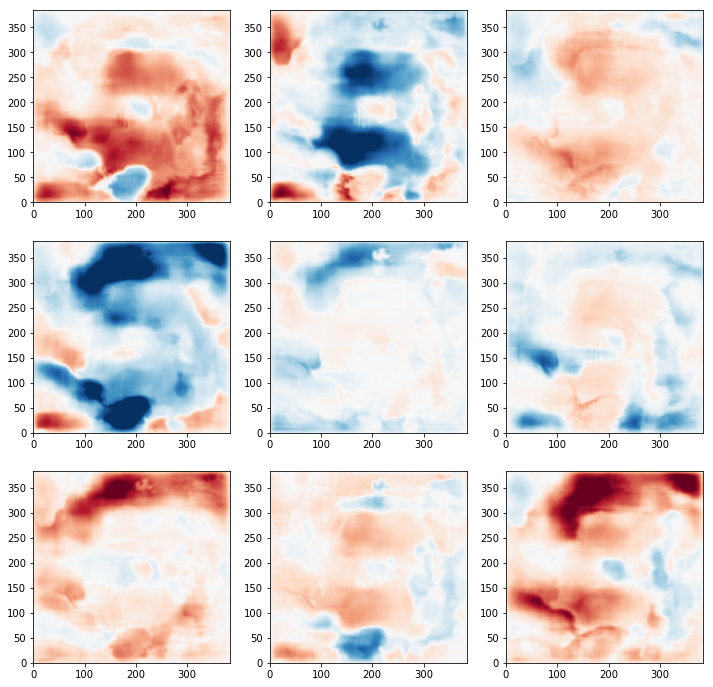

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(gaussian_filter(in_field[0, a], 2), vmin=-2, vmax=2, cmap="RdBu_r")

In [34]:
def mean_pool(input_data, out_size=(3, 3)):
    r_space = input_data.shape[0] // out_size[0]
    c_space = input_data.shape[1] // out_size[1]
    r_indices = np.arange(0, input_data.shape[0] + r_space, r_space)
    c_indices = np.arange(0, input_data.shape[1] + c_space, c_space)
    pooled_field = np.zeros(out_size)
    for r, r_index in enumerate(r_indices[:-1]):
        for c, c_index in enumerate(c_indices[:-1]):
            print(r, c, r_index, c_index)
            pooled_field[r,c] = input_data[r_index:r_indices[r+1], c_index:c_indices[c+1]].mean()
    return pooled_field


0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256


array([[0.43761305, 0.62830089, 0.93371758],
       [0.52734701, 0.68688046, 0.75098288],
       [0.046461  , 0.36626578, 0.16041501]])

0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256
0 0 0 0
0 1 0 128
0 2 0 256
1 0 128 0
1 1 128 128
1 2 128 256
2 0 256 0
2 1 256 128
2 2 256 256


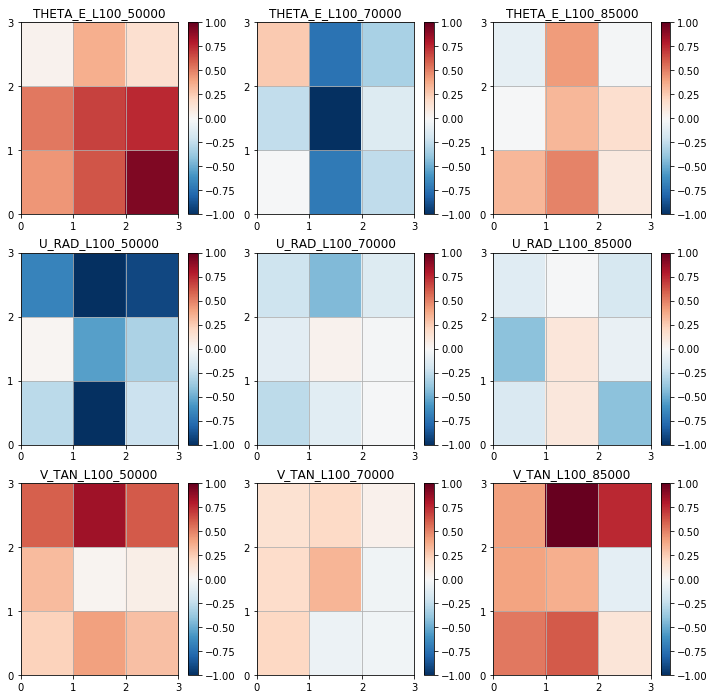

In [43]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for a, ax in enumerate(axes.ravel()):
    pc = ax.pcolormesh(mean_pool(in_field[0, a]), vmin=-1, vmax=1, cmap="RdBu_r")
    plt.colorbar(pc, ax=ax)
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_title(norms["variable"][a].values)
    ax.grid()
plt.savefig("bo_pos_coarse.png", dpi=200, bbox_inches="tight")

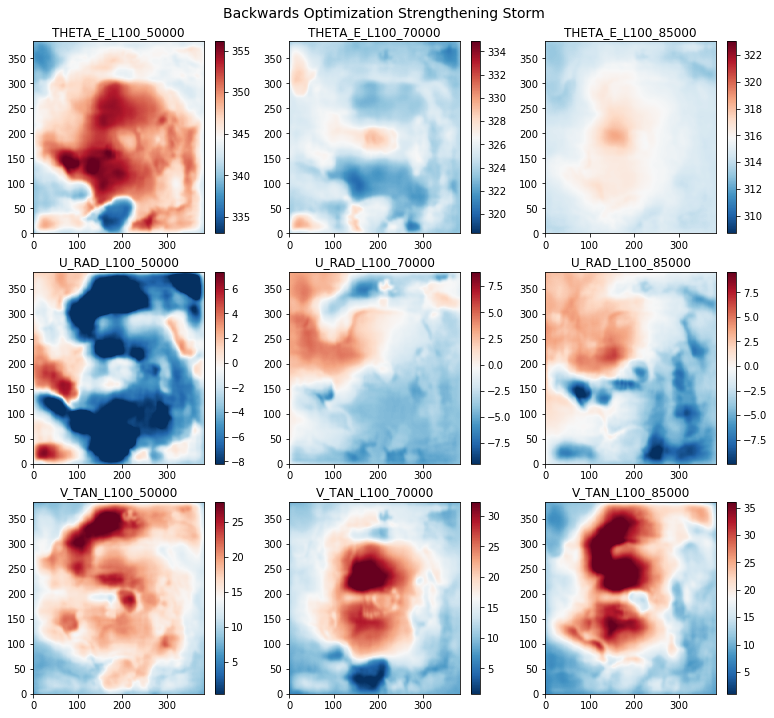

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(13, 12))
for a, ax in enumerate(axes.ravel()):
    var_mean = norms["local_norm_stats"][a].sel(statistic="mean").values
    var_sd = norms["local_norm_stats"][a].sel(statistic="standard_dev").values
    pc = ax.pcolormesh(gaussian_filter(in_field[0, a], 3) * var_sd + var_mean, vmin=var_mean.min()-5, 
                       vmax=var_mean.max()+5, cmap="RdBu_r")
    plt.colorbar(pc, ax=ax)
    ax.set_title(norms["variable"][a].values)
plt.suptitle("Backwards Optimization Strengthening Storm", y=0.92, fontsize=14)
plt.savefig("bo_pos_hurr_deep.png", dpi=200, bbox_inches="tight")

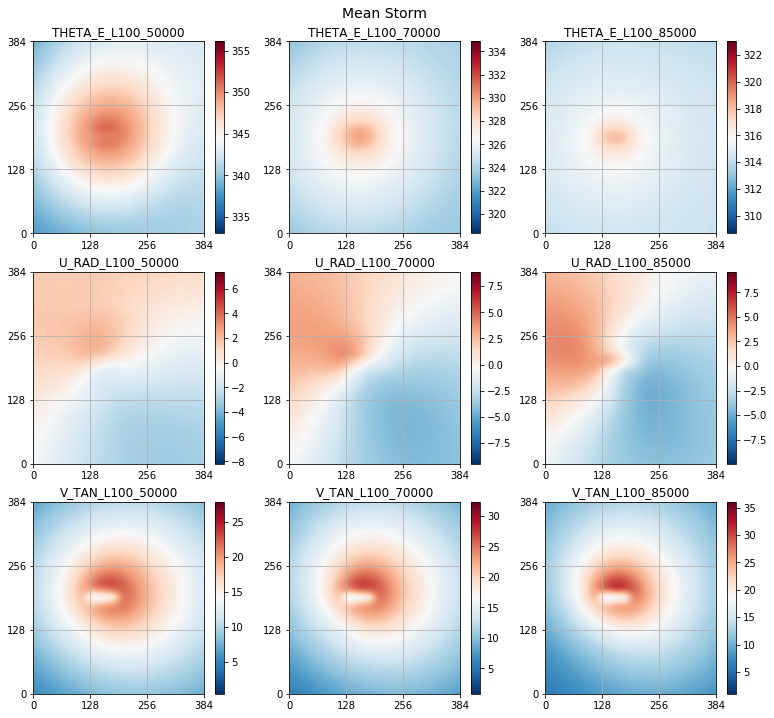

In [45]:
fig, axes = plt.subplots(3, 3, figsize=(13, 12))
for a, ax in enumerate(axes.ravel()):
    var_mean = norms["local_norm_stats"][a].sel(statistic="mean").values
    var_sd = norms["local_norm_stats"][a].sel(statistic="standard_dev").values
    pc = ax.pcolormesh(var_mean, vmin=var_mean.min()-5, vmax=var_mean.max()+5, cmap="RdBu_r")
    plt.colorbar(pc, ax=ax)
    ax.set_title(norms["variable"][a].values)
    ax.set_xticks(np.arange(0, 384 + 128, 384 // 3))
    ax.set_yticks(np.arange(0, 384 + 128, 384 //3))
    ax.grid()
plt.suptitle("Mean Storm", y=0.92, fontsize=14)
plt.savefig("bo_mean_hurr_deep.png", dpi=200, bbox_inches="tight")

In [26]:
loss = (res_model.output + 100) ** 2
grad = K.gradients(loss, [res_model.input])[0]
opt_func = K.function([res_model.input, K.learning_phase()], [grad, loss])
in_field_neg = np.zeros((1, 9, 384, 384))
for i in range(70):
    grad_field, loss_val = opt_func([in_field_neg, 0])
    in_field_neg -= grad_field
    print(loss_val[0, 0])

8838.194
7314.487
6550.274
5885.3755
5273.762
4725.715
4226.8174
3773.4922
3367.2407
3002.185
2674.9712
2380.9849
2118.6182
1884.4513
1675.932
1490.2671
1324.7957
1177.5927
1046.7194
930.2179
826.57086
734.40497
652.47675
579.61395
514.8584
457.2746
406.11572
360.65015
320.30655
284.43228
252.6058
224.29195
199.18362
176.86655
157.06168
139.44217
123.81469
109.92068
97.59611
86.64253
76.92582
68.29029
60.63147
53.82236
47.78232
42.415497
37.654167
33.42541
29.671207
26.33668
23.37788
20.749279
18.41707
16.345226
14.507885
12.875314
11.427992
10.142606
9.001923
7.989145
7.0907264
6.2932954
5.5857472
4.957037
4.3998737
3.9044774
3.4651957
3.0754914
2.7291305
2.4218714


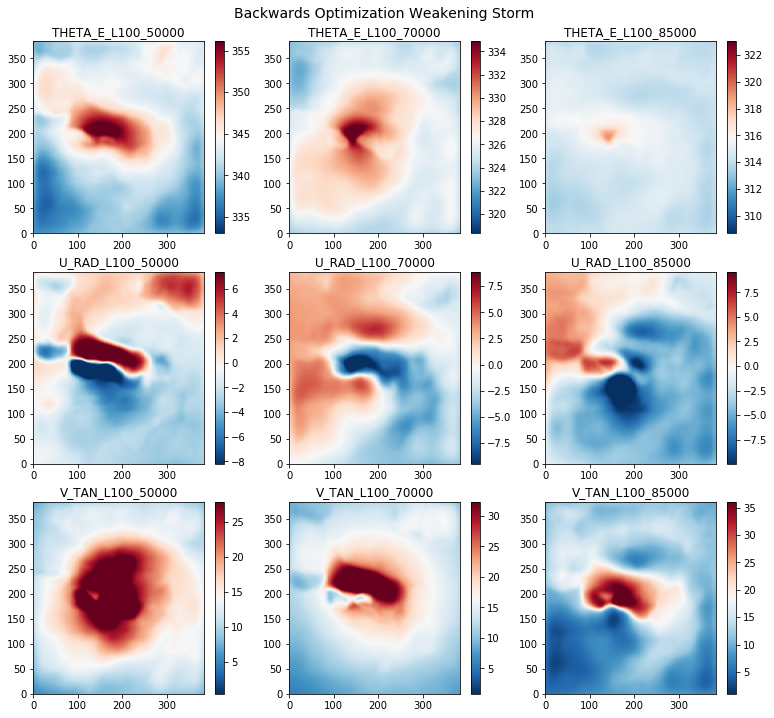

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(13, 12))
for a, ax in enumerate(axes.ravel()):
    var_mean = norms["local_norm_stats"][a].sel(statistic="mean").values
    var_sd = norms["local_norm_stats"][a].sel(statistic="standard_dev").values
    pc = ax.pcolormesh(gaussian_filter(in_field_neg[0, a], 4) * var_sd + var_mean, vmin=var_mean.min()-5, 
                       vmax=var_mean.max()+5,cmap="RdBu_r")
    plt.colorbar(pc, ax=ax)
    ax.set_title(norms["variable"][a].values)
plt.suptitle("Backwards Optimization Weakening Storm", y=0.92, fontsize=14)
plt.savefig("bo_neg_hurr_deep.png", dpi=200, bbox_inches="tight")